In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Defining a class describing Gaussian distribution:

In [2]:
class GaussianDist:
    
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def pred(self, x):
        return 1/(np.sqrt(2 * np.pi) * self.std)\
            * np.exp(-((x - self.mean) ** 2)/(2 * (self.std ** 2)))
    
    def update(self, mean, std):
        self.mean = mean
        self.std = std
        
    def report(self):
        print('mean: {}, std: {}'.format(self.mean, self.std))

## A class to handle linear combinations of multiple 1D Gaussian distributions and also implement the Expectation and Maximization steps.

In [92]:
class GaussianMixture:
    
    def __init__(self, dist, k, init_vals, data):
        self.dists = {}
        self.mweights = {}
        self.k = k
        for i in range(self.k):
            self.dists[i] = dist(init_vals[i]['mean'],
                                 init_vals[i]['std'])
            self.mweights[i] = init_vals[i]['weight']
        self.data = data
        self.n = data.shape[0]
        self.probs = np.zeros(shape=(self.n, self.k), dtype=np.float32)
        
    def expect(self):
        for i in range(self.k):
            self.probs[:, i] = self.dists[i].pred(self.data)
            self.probs[:, i] *= self.mweights[i]        
        self.probs /= self.probs.sum(axis=1).reshape(-1, 1)
        
    def maximize(self):
        nk = self.probs.sum(axis=0)
        for i in range(self.k):
            self.mweights[i] = nk[i] / self.n
            mean = (self.probs[:, i] * self.data).sum() / nk[i]
            std = np.sqrt((((self.data - mean) ** 2) * self.probs[:, i]).sum() / nk[i])
            self.dists[i].update(mean, std)
    
    # Computing average log likelihood
    def loglh(self):
        llh = 0.0
        for i in range(self.k):
            llh += self.mweights[i] * self.dists[i].pred(self.data)
        llh = np.log(llh)
        return - llh.mean()

    def report(self):
        for i in range(self.k):
            print('Distribution {}:'.format(i + 1))
            self.dists[i].report()

## Generating data to test the model

In [143]:
x1 = np.random.normal(loc=2.0, scale=12, size=(5000))

In [144]:
x2 = np.random.normal(loc=50.0, scale=20, size=(5000))

In [146]:
X = np.concatenate([x1, x2])
np.random.shuffle(X)

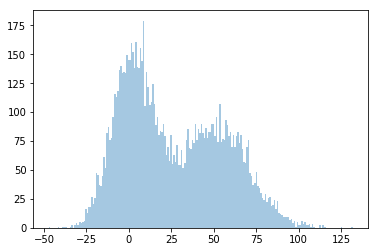

In [147]:
sns.distplot(X, bins=200, kde=False)

## Initializing a mixture model with 2 components with arbitary initial values for mean and standard deviations

In [149]:
threshold = 1e-6
init_vals = {}
init_vals[0] = {'mean': 5, 'std': 5, 'weight': 0.3}
init_vals[1] = {'mean': 20, 'std': 10, 'weight': 0.2}
mix = GaussianMixture(GaussianDist, 2, init_vals, X)

## Training with early stopping

In [150]:
best_score = 0.0
max_tolerance = 100
tolerance = 0
for i in range(10000):
    mix.expect()
    loglikelihood = mix.loglh()
    print(mix.loglh())
    if np.isnan(loglikelihood) or np.isinf(loglikelihood):
        break
    else:
        if np.abs(loglikelihood - best_score) >= threshold:
            best_score = loglikelihood
            mix.maximize()
            tolerance = 0
        else:
            tolerance += 1
            if tolerance >= max_tolerance:
                print('Tolerance exceeded, early stopping employed!')
                break

8.510389784
4.71684064377
4.70496428238
4.7013363545
4.69956149532
4.69833562334
4.69732554632
4.6964383464
4.69564142504
4.69491681211
4.69425122256
4.6936386135
4.69306980047
4.69254194754
4.69204852874
4.69158959784
4.69116166247
4.69075978633
4.69038881001
4.69004260519
4.68972353247
4.68942913955
4.68915976254
4.6889120553
4.68868973175
4.68848993443
4.68830989174
4.68814997529
4.68800865588
4.68788611189
4.68777731991
4.68768310068
4.68760155204
4.6875317972
4.68747116915
4.68742020228
4.68737638305
4.68733912721
4.68730766045
4.68728175094
4.68725884897
4.68723941349
4.68722387962
4.68721124741
4.68719994211
4.68719031335
4.68718261618
4.68717624578
4.68717067044
4.68716628973
4.68716260823
4.68715956623
4.68715699786
4.68715476857
4.68715309913
4.68715168149
4.6871504671
4.68714946383
4.6871487778
4.6871487778
4.6871487778
4.6871487778
4.6871487778
4.6871487778
4.6871487778
4.6871487778
4.6871487778
4.6871487778
4.6871487778
4.6871487778
4.6871487778
4.6871487778
4.6871487778
4

## Reporting the mean and standard deviation of the estimated distributions

In [151]:
mix.report()

Distribution 1:
mean: 2.0662763363917116, std: 12.003983130517984
Distribution 2:
mean: 50.45735611262232, std: 19.99410424693115


## Comparing with the original disribution

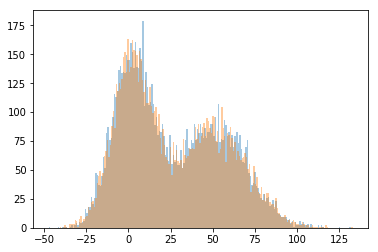

In [152]:
sns.distplot(X, bins=200, kde=False)
X_ = np.concatenate([np.random.normal(2.0662763363917116, 12.003983130517984, size=5000),
                     np.random.normal(50.45735611262232, 19.99410424693115, size=5000)])
sns.distplot(X_, bins=200, kde=False)

## Looks good!